In [1]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

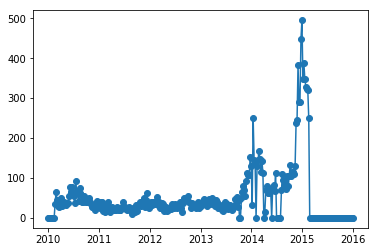

In [9]:
# Data preprocessing

# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(dates, df['Cases'], linestyle = '-')



In [13]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import StandardScaler
cols_to_norm = [ 'Rainfalls','Max. temperature','Min. temperature','Mean temp']
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])

print( df.head() )
# Create predictors
predictors = data.drop(['Cases'], axis=1).values
n_cols = predictors.shape[1] 

# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

train = np.reshape(train, (train.shape[0], train.shape[1],1))
test = np.reshape(test, (test.shape[0], test.shape[1],1))

   Year   Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0  2010  week1    0.0   0.505291             NaN          0.136972   
1  2010  week2    0.0   0.505291             NaN          0.136972   
2  2010  week3    0.0   0.505291             NaN          0.136972   
3  2010  week4    0.0   0.505291            22.0          0.136972   
4  2010  week5    0.0   0.505291             NaN          0.136972   

   Min. temperature  Mean temp  Fatality       Date  
0         -0.376173  -0.418524       0.0 2010-01-04  
1         -0.376173  -0.418524       0.0 2010-01-11  
2         -0.376173  -0.418524       0.0 2010-01-18  
3         -0.376173  -0.418524       0.0 2010-01-25  
4         -0.376173  -0.418524       0.0 2010-02-01  


TypeError: '(slice(0, 209, None), slice(None, None, None))' is an invalid key

In [ ]:
# Build and train the model
from tensorflow.keras import layers
from tensorflow import keras 
from keras import LSTM
from keras import Dropout
import tensorflow as tf
import numpy as py

# Input layer
model = keras.Sequential() 
model.add( LSTM( units = 50, return_sequence = True, input_shape = (train.shape[1],1) ) )
model.add(Dropout(0.2))
model.add( LSTM( units = 50, return_sequence = True, input_shape = (train.shape[1],1) ) )
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Output layer
model.add(layers.Dense(1, activation='sigmoid')) 

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) 

# Fit the model
model.fit(train, test, epochs=40,  verbose=False )

# Predict
predicted_case = model.predict(test)
print( predicted_case)